In [2]:
import h5py
import healpy as hp
import netCDF4
import numpy as np

try:
    from numpy import trapezoid
except ImportError:
    from numpy import trapz as trapezoid
import pytest
import xarray as xr
from numpy.testing import assert_allclose

from pysm3 import units as u
from pysm3 import utils
from pysm3.models.catalog import (
    PointSourceCatalog,
    evaluate_model,
    evaluate_poly,
    aggregate,
)
from pysm3.utils import car_aperture_photometry, healpix_aperture_photometry

In [3]:
num_sources = 2
indices = np.arange(num_sources)

dims = ("index", "power")
catalog = xr.Dataset(
    {
        "logpolycoefflux": (dims, np.zeros((len(indices), 5), dtype=np.float64)),
        "logpolycoefpolflux": (dims, np.zeros((len(indices), 5), dtype=np.float64)),
    },
    coords={
        "index": indices,
        "power": np.arange(5)[::-1],
        "theta": ("index", np.array([np.pi / 4, np.pi / 2])),
        "phi": ("index", np.zeros(num_sources)),
    },
)
for field in ["theta", "phi"]:
    catalog[field].attrs["units"] = "rad"
for field in ["logpolycoefflux", "logpolycoefpolflux"]:
    catalog[field].attrs["units"] = "Jy"
catalog["logpolycoefflux"].loc[{"index": 0, "power": 0}] = 3.7
catalog["logpolycoefflux"].loc[{"index": 1, "power": 1}] = 2
catalog["logpolycoefpolflux"].loc[{"index": 1, "power": 0}] = 5
fn = "test_catalog.h5"
print(netCDF4.__version__)
catalog.to_netcdf(str(fn), format="NETCDF4")  # requires netcdf4 package

1.7.1


In [4]:

# resolution of the map is 7 degrees, beam is 0.5 degrees
# all flux should be in the central pixel
nside = 32
catalog = PointSourceCatalog(fn, nside=nside)
freqs = np.exp(np.array([3, 4])) * u.GHz  # ~ 20 and ~ 55 GHz
weights = np.array([1, 1], dtype=np.float64)
weights /= trapezoid(weights, x=freqs.to_value(u.GHz))

scaling_factor = utils.bandpass_unit_conversion(
    freqs, weights, input_unit=u.uK_RJ, output_unit=u.Jy / u.sr
)
catalog_flux = catalog.get_fluxes(freqs, weights=weights)

fwhm = 2 * u.deg
output_map = catalog.get_emission(
    freqs,
    weights=weights,
    output_units=u.uK_RJ,
    fwhm=fwhm,
    return_car=True,
)
assert_allclose(
    output_map[0].argmax(unit="coord"), np.array([0, 0]), atol=1e-2, rtol=1e-3
)

box_half_size_rad = 3 * fwhm.to_value(u.rad)
box_center = [0, 0]
box = np.array(
    [
        [box_center[0] - box_half_size_rad, box_center[1] - box_half_size_rad],
        [box_center[0] + box_half_size_rad, box_center[1] + box_half_size_rad],
    ]
)  # in radians
cutout = output_map[0].submap(box) * scaling_factor.value
flux = car_aperture_photometry(cutout, 2 * fwhm.to_value(u.rad)) * u.Jy
assert_allclose(flux, catalog_flux.max(), rtol=1e-3)

catalog_flux_P = catalog.get_fluxes(
    freqs, weights=weights, coeff="logpolycoefpolflux"
)
np.random.seed(56567)
psirand = np.random.uniform(low=-np.pi / 2.0, high=np.pi / 2.0, size=2)
cutout = output_map[1].submap(box) * scaling_factor.value
flux = car_aperture_photometry(cutout, 2 * fwhm.to_value(u.rad)) * u.Jy
assert_allclose(flux, catalog_flux_P[1] * np.cos(2 * psirand[1]), rtol=1e-3)

AssertionError: 
Not equal to tolerance rtol=0.001, atol=0

Mismatched elements: 1 / 1 (100%)
Max absolute difference: 0.1759937
Max relative difference: 1.00000408
 x: Quantity(7.176184e-07, unit='Jy')
 y: Quantity(-0.175993, unit='Jy')

In [ ]:
print(catalog_flux, catalog_flux_P)

[3.7        7.76159416] Jy [0. 5.] Jy


In [10]:
cutout = output_map[2].submap(box) * scaling_factor.value
flux = car_aperture_photometry(cutout, 2 * fwhm.to_value(u.rad)) * u.Jy
assert_allclose(flux, catalog_flux_P[1] * np.sin(2 * psirand[1]), rtol=1e-3)

AssertionError: 
Not equal to tolerance rtol=0.001, atol=0

Mismatched elements: 1 / 1 (100%)
Max absolute difference: 4.9969024
Max relative difference: 1.00000014
 x: Quantity(7.176184e-07, unit='Jy')
 y: Quantity(-4.996902, unit='Jy')

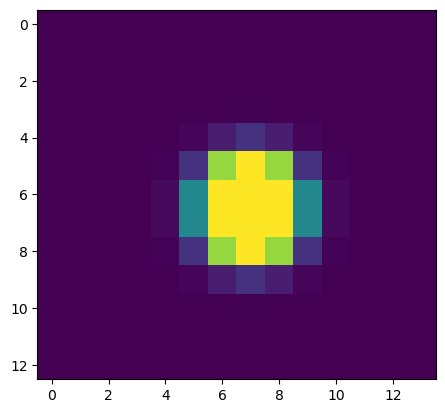

In [20]:
plt.imshow(output_map[0].submap(box) * scaling_factor.value, vmin=0, vmax=1000)

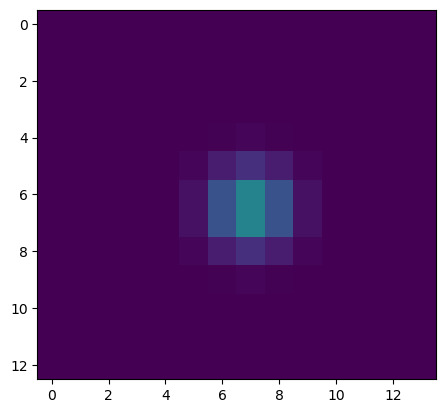

In [22]:

plt.imshow(output_map[1].submap(box) * scaling_factor.value, vmin=0, vmax=1e-3)

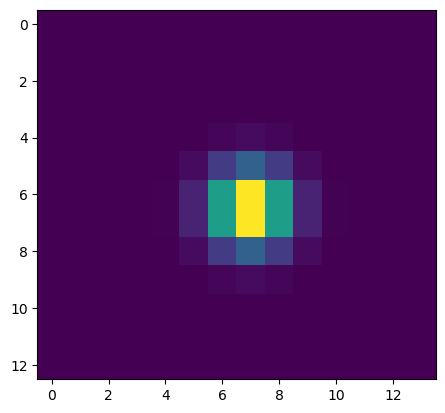

In [7]:
import matplotlib.pyplot as plt

plt.imshow(cutout)

In [8]:
cutout.max()

array(0.00044921, dtype=float32)

In [9]:
catalog_flux

<Quantity [3.7       , 7.76159416] Jy>